One of my hobbies is taking photographs of astronomical objects. The most stunning images combine operating the equipment under a dark sky with skillful processing using a variety of software. In fact, one rule of thumb in the astrophotography community is that for every hour you spend working with the equipment (driving to your site, setting everything up, capturing the hours long exposures, and so on), you should spend at least one hour processing the image. However, for the level of importance that processing has, there is very little data about what’s commonly used. I’d like to explore the processing software and techniques in the software that people use. What software do people commonly use for different types of astronomical object? What processing do they perform in that software? What processing steps are often used by images that are well received by the community?

There is one big website (www.astrobin.com) which archives images people have taken. It allows people to add tags which include the equipment they use, which are frequently filled in. This gives people the ability to search for the equipment they have and see images other people have taken. You are also able to search for an object and see what equipment produces the best results. Astrobin does have tags for software as well, but from my experience they’re used infrequently. Even when these tags are used there are many details missing.

However, there is another source for data. The Reddit astrophotography subreddit has strict moderation which requires anyone who posts an image to include details about the software they used to create the image. The downside of relying on reddit comments is that they’re written in natural language rather than a nice tag based system. However, the power of natural language processing should be able to help with that! Reddit does have a couple advantages beyond the processing details though. First, many posts have been assigned a label either by the poster or a moderator that gives the subject matter of the post. For example, “DSOs” for images of deep space objects or “Lunar” for photos of the moon. Second, the moderators enforce rules about the title of the post which require the name of the object photographed and little or no other words. This will allow for very granular analysis because it will be possible to analyze which processes are used on particular targets or types of targets. Finally, reddit gives a platform for community feedback. The easiest to use source of feedback is the score of the post, but it would also be possible to use sentiment analysis on the comments and see what people are saying.

The first step of this analysis is to gather the data from Reddit. The official Reddit API only gives access to 1000 posts in the sort order you choose. Even by combining multiple sorting orders, I could only reach a few thousand posts. Instead, I started by using www.pushshift.io, which has archived every reddit post and provided an API to access and search it. While they do not provide a Python API, a package called psaw (Pushshift API Wrapper) was released very recenly. This API makes it easy to get a list of every post on /r/astrophotography. Then to access the comments and get the processing information I want, I return to the official Reddit API, accessed via the praw (Python Reddit API Wrapper) package.

For initial analysis, I have naively assumed that the first comment made by the person who made the post contains the image details. However, this may not always be the case. Frequently the poster will provide an overview and a moderator must remind them to give more details. In addition to this comment, I have stored the (unique) submission ID, the title, flair, and score of the post, the URL of the image, the username of the person who posted the thread, and the time the post was created. I stored all of this in a Pandas DataFrame to enable exploratory data analysis. I have also saved the data to a CSV file which can be found here: https://github.com/erik-hasse/astrophotography-analysis/blob/master/data.csv

In [1]:
import praw
from psaw import PushshiftAPI
import numpy as np
import pandas as pd

from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [74]:
# Take in the comments on a post and the name of the poster, and then return the oldest comment
# made by that person.
def getOldestOPComment(comments,op):
    commentText = ''
    commentAge = None
    comments.replace_more()
    for x in comments.list():
        if(x.author != None):
            if(x.author.name == op):
                if(commentAge == None or commentAge > x.created_utc):
                    commentAge = x.created_utc
                    commentText = x.body
    return commentText

In [5]:
# Initialize the two APIs I need, then get a list of every post on /r/astrophotography.
# the filter parameter to search_submissions allows me to get only the data that I need.
reddit = praw.Reddit(client_id='swC30Mawflu56A',
                     client_secret='REDACTED FOR SECURITY',
                     user_agent='python:haerik.datascience.astrophotography:v1.0.0 (by /u/haerik)')
api = PushshiftAPI()
allPosts = list(api.search_submissions(subreddit='astrophotography', limit=50000,filter=['title','link_flair_text','id','author','created_utc','url','score']))

# Build the data up to a Panda's DataFrame. Due to Reddit's API rate limits (which are
# usefully enforced by praw), this takes a significant amount of time to run.
df = pd.DataFrame(columns = ['submission_id','post_title','link_flair','created_utc','author','url','first_op_comment','score'])
i=0
for submission in allPosts:
    entry = [
        submission.id,
        submission.title,
        submission.link_flair_text if hasattr(submission,'link_flair_text') else np.nan,
        submission.created_utc,
        submission.author,
        submission.url,
        getOldestOPComment(reddit.submission(id=submission.id).comments,submission.author),
        submission.score
    ]
    df.loc[i] = entry
    if(i % 1000 == 0):
        print(i)
    i += 1

# Save to a CSV so that I can continue work later without getting everything again.
df.to_csv('data.csv',encoding='utf-8')

In [264]:
# Restore from the CSV. To make things easier, I want to fill the comments with
# blanks instead of NaNs
df = pd.read_csv('data.csv')
df['first_op_comment'] = df['first_op_comment'].fillna(value='')

Now that the data has been gathered, we can do some preliminary analysis of it. For now I'm going to stick to just counting words that I expect to see. Future analysis can be done with more sophisticated NLP techniques. Right now I'm going to focus just on the software that was used, rather than the steps taken within that software.

Astrophotographers commonly use 6 pieces of software. Adobe Photoshop and Lightroom are general purpose photography tools, but the rest are mostly specialized for the purpose. Using the TextBlob package, I'm able to check whether the name of the software appears in the comments and store a boolean for that software in a new column. I also check for common abbreviations, and in the case of PixInsight I check for the possibility of someone writing "Pix Insight".

In [265]:
df['comment_tb'] = df['first_op_comment'].map(lambda x: TextBlob(x))
df['used_PI'] = df['comment_tb'].map(lambda x: (x.word_counts['pixinsight']+x.word_counts['pix']+x.word_counts['PI']) > 0 )
df['used_PS'] = df['comment_tb'].map(lambda x: (x.word_counts['photoshop']+x.word_counts['shop']+x.word_counts['ps']) > 0)
df['used_lightroom'] = df['comment_tb'].map(lambda x: x.word_counts['lightroom'] > 0)
df['used_DSS'] = df['comment_tb'].map(lambda x: (x.word_counts['dss'] + x.word_counts['deepskystacker']) > 0)
df['used_autostakkert'] = df['comment_tb'].map(lambda x: x.word_counts['autostakkert'] > 0)
df['used_registax'] = df['comment_tb'].map(lambda x: x.word_counts['registax'] > 0)

Now I want to make a few plots. First, how often do posters use each piece of software on different types of objects? And second, relative to the average score for a type of object, what software produces the best results as judged by Reddit's voting system?

Due to time constraints I was not able to get the plots I desired directly out of my DataFrame. So instead I constructed a new one with the information I want. While this solution isn't as elegant, the information it displays is exactly the same.

In [273]:
plotData = pd.DataFrame(columns=['software_name','link_flair','percent','relative_score'])
# A handful of posts are missing the score for some reason, so we'll just throw them away
df = df.dropna(subset=['score'])
i=0
for software in ['PI','PS','lightroom','DSS','autostakkert','registax']:
    for flair in ['DSOs','Lunar','Planetary','Widefield','Solar']:
        #Calculate the percent of posts for a given flair that used the software
        percent = 100 * sum(df[df['link_flair']==flair]['used_' + software])/len(df[df['link_flair']==flair])
        
        # To avoid skewing data, only compute the relative score when we have at least 15 examples
        if len(df[(df['link_flair'] == flair) & (df['used_' + software])]) >= 15:
            relativeScore = (np.average(df[(df['link_flair'] == flair) & (df['used_' + software])]['score'])
                                /np.average(df[df['link_flair'] == flair]['score']) - 1) * 100
        else:
            relativeScore = np.nan
        entry = [
            software,
            flair,
            percent,
            relativeScore
        ]
        plotData.loc[i]= entry
        i += 1
        

Text(0.5,1,'Usage Rates of Processing Software on /r/astrophotography')

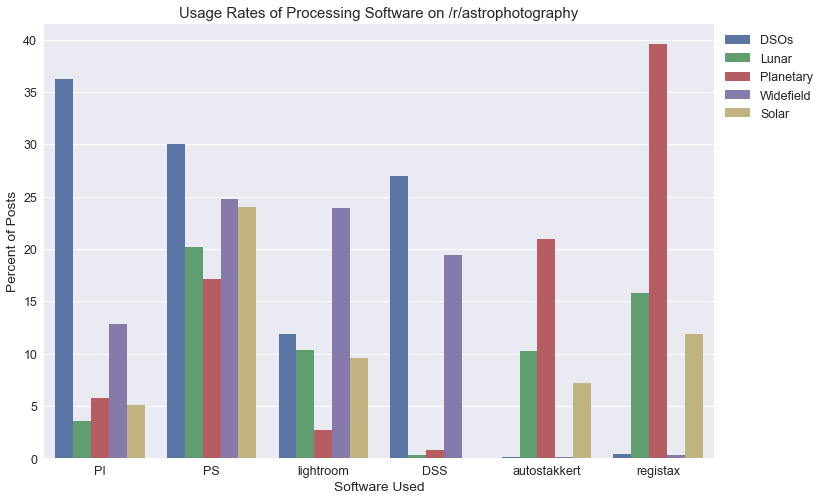

In [274]:
sns.set(font_scale=1.25)
plt.figure(figsize=(12,8))
sns.barplot(x='software_name',y='percent',hue='link_flair',data=plotData)
plt.legend(bbox_to_anchor=[1,1])
plt.xlabel('Software Used')
plt.ylabel('Percent of Posts')
plt.title('Usage Rates of Processing Software on /r/astrophotography')

From this chart, we can draw some data-driven conclusions about how the different software is used. First, PixInsight is very popular for deep space objects. This is reasonable because that's the main reason it was developed. However, its tools are still useful for other types of targets. Next, Photoshop is used consistently with all types of objects, which again makes sense considering that it's an all purpose photo editing program. Lightroom is only rarely used for planetary photos, but regularly used for widefield photos. Because I haven't used Lightroom for my photography, this is the first surprising conclusion for me. If I were to guess, it's because widefield photographs can be taken by people with traditional photography equipment, and traditional photographers are more likely to be familiar with Lightroom, which makes for an easy transition into astrophotography. On the other hand, people who become interested directly in astrophotography are more likely to use specialized tools like PixInsight and DeepSkyStacker. Fourth, DeepSkyStacker is used almost exclusively for deep space and widefield photographs, which is not surprising given its name. Finally, Autostakkert and Registax are used almost exclusively for lunar, planetary, and solar images. This is not surprising because these are the objects they were designed for. What is unexpected in my opinion is that their usage on different targets is proportionally very similar, although Registax is more complicated.

Overall, this chart has brought out a couple conclusions that I don't believe would have been easy to see without pulling the data!

Text(0.5,1,'Percent Change from the Average Score on /r/astrophotography for Software and Targes')

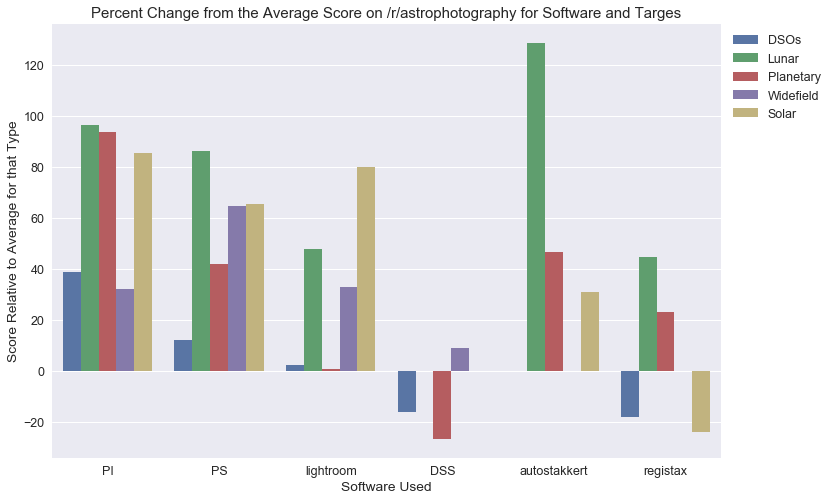

In [276]:
sns.set(font_scale=1.25)
plt.figure(figsize=(12,8))
sns.barplot(x='software_name',y='relative_score',hue='link_flair',data=plotData)
plt.legend(bbox_to_anchor=[1,1])
plt.xlabel('Software Used')
plt.ylabel('Score Relative to Average for that Type')
plt.title('Percent Change from the Average Score on /r/astrophotography for Software and Targes')

This plot shows the percent change of average scores of posts with each link flair processed with certain software as compared to the average for the link flair regardless of processing. We can see that photos processed with PixInsight generally perform better than photos of similar objects across the board, although it appears to be especially useful for lunar, planetary, and solar images. Next, despite the frequency of people using Photoshop for deep space objects, the scores of those posts are not substantially higher than average, but it is useful for other types of posts. Similarly, Lightroom is apparently not very useful for deep space and planetary photographs, but it does improve other images. Perhaps most interesting to me is that images processed with DeepSkyStacker perform worse on average. One explanation I can come up with for this is that DSS is frequently used by people who are new to the hobby, which means their images are not as good as more experienced photographers. Finally, autostakkert is very useful for lunar images, and performs better across the board than Registax, even though Registax is more popular as shown by the previous plot.